In [1]:
#import argparse
import math
import h5py
import numpy as np
import tensorflow as tf
import socket
import importlib
import os
import sys
BASE_DIR = '/data/code3/mil_pointnet'
sys.path.append(BASE_DIR)
sys.path.append(os.path.join(BASE_DIR, 'models'))
sys.path.append(os.path.join(BASE_DIR, 'utils'))
#import provider
import tf_util

In [2]:
BATCH_SIZE = 32
NUM_POINT = 1024 #'Point Number [256/512/1024/2048] 
MAX_EPOCH = 250
BASE_LEARNING_RATE = 0.001
GPU_INDEX = 0
MOMENTUM = 0.9
OPTIMIZER = 'adam'
DECAY_STEP = 200000
DECAY_RATE = 0.7
MODEL = importlib.import_module('pointnet_cls') # import network module
MODEL_FILE = os.path.join(BASE_DIR, 'models', 'pointnet_cls'+'.py')
LOG_DIR = 'log'

In [3]:
import provider

In [4]:
if not os.path.exists(LOG_DIR): os.mkdir(LOG_DIR)

In [5]:
os.system('cp %s %s' % (MODEL_FILE, LOG_DIR)) # bkp of model def
os.system('cp train.py %s' % (LOG_DIR)) # bkp of train procedure

0

In [6]:
LOG_FOUT = open(os.path.join(LOG_DIR, 'log_train.txt'), 'w')
#LOG_FOUT.write(str(FLAGS)+'\n')

### ss

In [7]:
MAX_NUM_POINT = 2048
NUM_CLASSES = 40 # for ModelNet40

# batchnorm paprameters
BN_INIT_DECAY = 0.5
BN_DECAY_DECAY_RATE = 0.5
BN_DECAY_DECAY_STEP = float(DECAY_STEP)
BN_DECAY_CLIP = 0.99

In [8]:
HOSTNAME = socket.gethostname()
HOSTNAME

'milton-ThinkCentre-M93p'

In [9]:
# ModelNet40 official train/test split
TRAIN_FILES = provider.getDataFiles( \
    os.path.join(BASE_DIR, 'data/modelnet40_ply_hdf5_2048/train_files.txt'))
TEST_FILES = provider.getDataFiles(\
    os.path.join(BASE_DIR, 'data/modelnet40_ply_hdf5_2048/test_files.txt'))

In [10]:
type(TRAIN_FILES)

list

In [11]:
TRAIN_FILES

['data/modelnet40_ply_hdf5_2048/ply_data_train0.h5',
 'data/modelnet40_ply_hdf5_2048/ply_data_train1.h5',
 'data/modelnet40_ply_hdf5_2048/ply_data_train2.h5',
 'data/modelnet40_ply_hdf5_2048/ply_data_train3.h5',
 'data/modelnet40_ply_hdf5_2048/ply_data_train4.h5']

In [24]:
??tf.train.exponential_decay

### some utility functions

In [12]:
def log_string(out_str):
    LOG_FOUT.write(out_str+'\n')
    LOG_FOUT.flush()
    print(out_str)


def get_learning_rate(batch):
    learning_rate = tf.train.exponential_decay(
                        learning_rate=BASE_LEARNING_RATE,  # Base learning rate.=0.001
                        global_step=batch * BATCH_SIZE,  # Current index into the dataset.=batch*32
                        decay_steps=DECAY_STEP,          # Decay step.=200,000
                        decay_rate=DECAY_RATE,          # Decay rate.=0.7
                        staircase=True)
    learning_rate = tf.maximum(learning_rate, 0.00001) # CLIP THE LEARNING RATE!
    return learning_rate        

def get_bn_decay(batch):
    bn_momentum = tf.train.exponential_decay(
                      BN_INIT_DECAY, # Base bn decay.=0.5
                      batch*BATCH_SIZE, # Current index into the dataset.=batch*32
                      BN_DECAY_DECAY_STEP, # BN decay step.=200,000.0
                      BN_DECAY_DECAY_RATE, # BN decay rate.=0.5
                      staircase=True)
    bn_decay = tf.minimum(BN_DECAY_CLIP, 1 - bn_momentum) # BN_DECAY_CLIP=0.99, 
    return bn_decay

### Core function : train()

In [13]:
g = tf.get_default_graph()
tf.device('/gpu:0')

In [14]:
batch_size = BATCH_SIZE
num_point = NUM_POINT

### create placeholder for input

In [15]:
pointclouds_pl = tf.placeholder(tf.float32, shape=(batch_size, num_point, 3))
labels_pl = tf.placeholder(tf.int32, shape=(batch_size))
is_training_pl = tf.placeholder(tf.bool, shape=())

In [ ]:
vs = 

In [ ]:
"""
def train():
    with tf.Graph().as_default():
        with tf.device('/gpu:'+str(GPU_INDEX)):
            pointclouds_pl, labels_pl = MODEL.placeholder_inputs(BATCH_SIZE, NUM_POINT)
            is_training_pl = tf.placeholder(tf.bool, shape=())
            print(is_training_pl)
            
            # Note the global_step=batch parameter to minimize. 
            # That tells the optimizer to helpfully increment the 'batch' parameter for you every time it trains.
            batch = tf.Variable(0)
            bn_decay = get_bn_decay(batch)
            tf.summary.scalar('bn_decay', bn_decay)

            # Get model and loss 
            pred, end_points = MODEL.get_model(pointclouds_pl, is_training_pl, bn_decay=bn_decay)
            loss = MODEL.get_loss(pred, labels_pl, end_points)
            tf.summary.scalar('loss', loss)

            correct = tf.equal(tf.argmax(pred, 1), tf.to_int64(labels_pl))
            accuracy = tf.reduce_sum(tf.cast(correct, tf.float32)) / float(BATCH_SIZE)
            tf.summary.scalar('accuracy', accuracy)

            # Get training operator
            learning_rate = get_learning_rate(batch)
            tf.summary.scalar('learning_rate', learning_rate)
            if OPTIMIZER == 'momentum':
                optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=MOMENTUM)
            elif OPTIMIZER == 'adam':
                optimizer = tf.train.AdamOptimizer(learning_rate)
            train_op = optimizer.minimize(loss, global_step=batch)
            
            # Add ops to save and restore all the variables.
            saver = tf.train.Saver()
            
        # Create a session
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        config.allow_soft_placement = True
        config.log_device_placement = False
        sess = tf.Session(config=config)

        # Add summary writers
        #merged = tf.merge_all_summaries()
        merged = tf.summary.merge_all()
        train_writer = tf.summary.FileWriter(os.path.join(LOG_DIR, 'train'),
                                  sess.graph)
        test_writer = tf.summary.FileWriter(os.path.join(LOG_DIR, 'test'))

        # Init variables
        init = tf.global_variables_initializer()
        # To fix the bug introduced in TF 0.12.1 as in
        # http://stackoverflow.com/questions/41543774/invalidargumenterror-for-tensor-bool-tensorflow-0-12-1
        #sess.run(init)
        sess.run(init, {is_training_pl: True})

        ops = {'pointclouds_pl': pointclouds_pl,
               'labels_pl': labels_pl,
               'is_training_pl': is_training_pl,
               'pred': pred,
               'loss': loss,
               'train_op': train_op,
               'merged': merged,
               'step': batch}

        for epoch in range(MAX_EPOCH):
            log_string('**** EPOCH %03d ****' % (epoch))
            sys.stdout.flush()
             
            train_one_epoch(sess, ops, train_writer)
            eval_one_epoch(sess, ops, test_writer)
            
            # Save the variables to disk.
            if epoch % 10 == 0:
                save_path = saver.save(sess, os.path.join(LOG_DIR, "model.ckpt"))
                log_string("Model saved in file: %s" % save_path)
                """

In [ ]:
"""g = tf.Graph()
with g.as_default():
	x = tf.add(3, 5)
sess = tf.Session(graph=g)
with tf.Session() as sess:
	sess.run(x)
    """

In [16]:
# display nodes in the graph
g = tf.get_default_graph()
[node.name for node in g.as_graph_def().node]

[u'Placeholder', u'Placeholder_1', u'Placeholder_2']

In [30]:
# display trainable params
vs = tf.trainable_variables()
for v in vs:
    print(v)

Tensor("Variable/read:0", shape=(), dtype=int32)


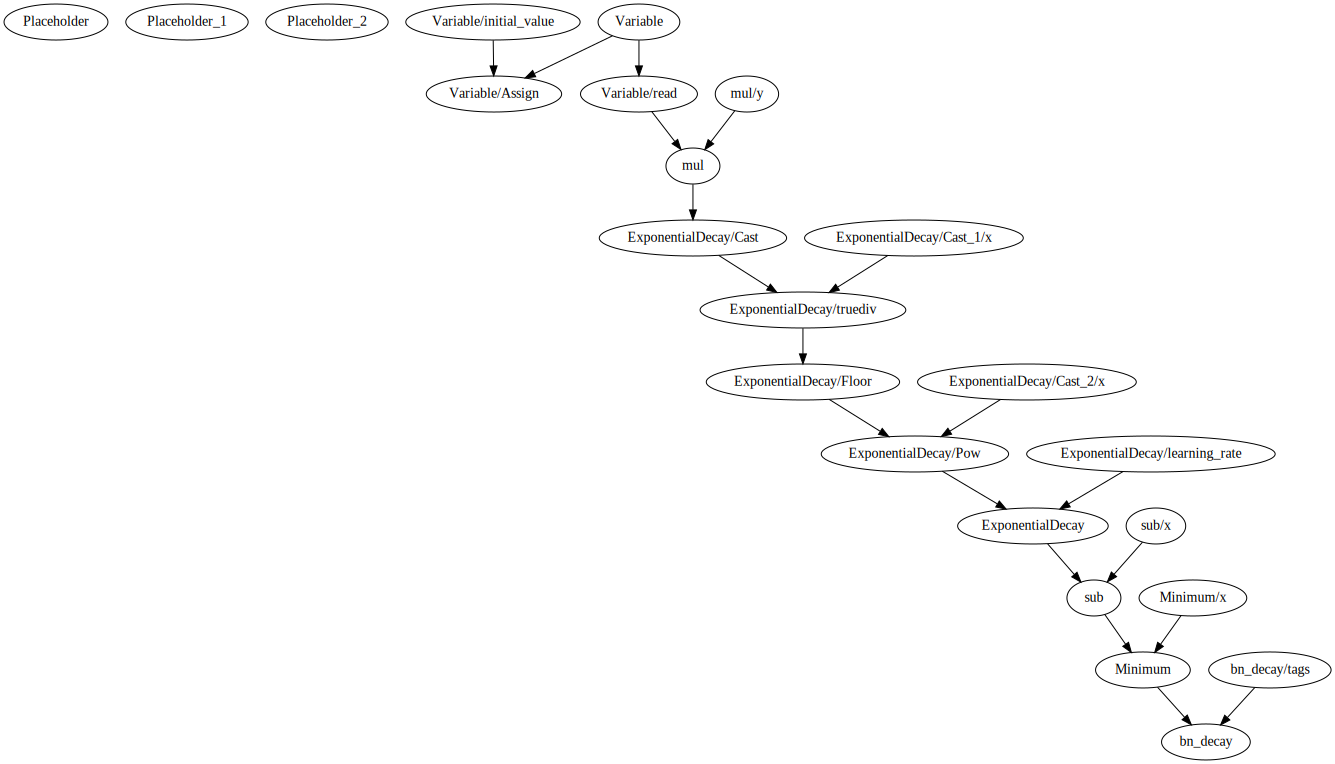

In [32]:
from graphviz import Digraph

dot = Digraph()

for n in g.as_graph_def().node:
    # Each node has a name and a label. The name identifies the node
    # while the label is what will be displayed in the graph.
    # We're using the name as a label for simplicity.
    dot.node(n.name, label=n.name)
    
    for i in n.input:
        # Edges are determined by the names of the nodes
        dot.edge(i, n.name)
        
# Jupyter can automatically display the DOT graph,
# which allows us to just return it as a value.
dot

In [17]:
# Note the global_step=batch parameter to minimize.
# That tells the optimizer to helpfully increment the 'batch' parameter for you every time it trains.
# batch variable is run inside the graph
batch = tf.Variable(0)
bn_decay = get_bn_decay(batch)
tf.summary.scalar('bn_decay', bn_decay)

<tf.Tensor 'bn_decay:0' shape=() dtype=string>

### # Get model and loss 

In [ ]:
# Get model and loss 
#pred, end_points = MODEL.get_model(pointclouds_pl, is_training_pl, bn_decay=bn_decay)

In [18]:
""" Classification PointNet, input is BxNx3, output Bx40 """
batch_size = pointclouds_pl.get_shape()[0].value # 32
num_point = pointclouds_pl.get_shape()[1].value # 1024
end_points = {}

In [19]:
from transform_nets import input_transform_net, feature_transform_net

In [20]:
with tf.variable_scope('transform_net1') as sc:
    transform = input_transform_net(pointclouds_pl, is_training_pl, bn_decay, K=3)

In [38]:
# display trainable params
vs = tf.trainable_variables()
for v in vs:
    print(v)

Tensor("Variable/read:0", shape=(), dtype=int32)
Tensor("transform_net1/tconv1/weights/read:0", shape=(1, 3, 1, 64), dtype=float32, device=/device:CPU:0)
Tensor("transform_net1/tconv1/biases/read:0", shape=(64,), dtype=float32, device=/device:CPU:0)
Tensor("transform_net1_1/tconv1/bn/beta/read:0", shape=(64,), dtype=float32)
Tensor("transform_net1_1/tconv1/bn/gamma/read:0", shape=(64,), dtype=float32)
Tensor("transform_net1/tconv2/weights/read:0", shape=(1, 1, 64, 128), dtype=float32, device=/device:CPU:0)
Tensor("transform_net1/tconv2/biases/read:0", shape=(128,), dtype=float32, device=/device:CPU:0)
Tensor("transform_net1_1/tconv2/bn/beta/read:0", shape=(128,), dtype=float32)
Tensor("transform_net1_1/tconv2/bn/gamma/read:0", shape=(128,), dtype=float32)
Tensor("transform_net1/tconv3/weights/read:0", shape=(1, 1, 128, 1024), dtype=float32, device=/device:CPU:0)
Tensor("transform_net1/tconv3/biases/read:0", shape=(1024,), dtype=float32, device=/device:CPU:0)
Tensor("transform_net1_1/tc

In [39]:
# display nodes in the graph
g = tf.get_default_graph()
[node.name for node in g.as_graph_def().node]

[u'Placeholder',
 u'Placeholder_1',
 u'Placeholder_2',
 u'Variable/initial_value',
 u'Variable',
 u'Variable/Assign',
 u'Variable/read',
 u'mul/y',
 u'mul',
 u'ExponentialDecay/learning_rate',
 u'ExponentialDecay/Cast',
 u'ExponentialDecay/Cast_1/x',
 u'ExponentialDecay/Cast_2/x',
 u'ExponentialDecay/truediv',
 u'ExponentialDecay/Floor',
 u'ExponentialDecay/Pow',
 u'ExponentialDecay',
 u'sub/x',
 u'sub',
 u'Minimum/x',
 u'Minimum',
 u'bn_decay/tags',
 u'bn_decay',
 u'transform_net1_1/ExpandDims/dim',
 u'transform_net1_1/ExpandDims',
 u'transform_net1/tconv1/weights/Initializer/random_uniform/shape',
 u'transform_net1/tconv1/weights/Initializer/random_uniform/min',
 u'transform_net1/tconv1/weights/Initializer/random_uniform/max',
 u'transform_net1/tconv1/weights/Initializer/random_uniform/RandomUniform',
 u'transform_net1/tconv1/weights/Initializer/random_uniform/sub',
 u'transform_net1/tconv1/weights/Initializer/random_uniform/mul',
 u'transform_net1/tconv1/weights/Initializer/random_u

In [21]:
transform

<tf.Tensor 'transform_net1/Reshape_1:0' shape=(32, 3, 3) dtype=float32>

In [22]:
point_cloud_transformed = tf.matmul(pointclouds_pl, transform)

In [23]:
point_cloud_transformed

<tf.Tensor 'MatMul:0' shape=(32, 1024, 3) dtype=float32>

In [24]:
input_image = tf.expand_dims(point_cloud_transformed, -1)

In [25]:
net = tf_util.conv2d(inputs=input_image, num_output_channels=64, kernel_size=[1,3],
                     padding='VALID', stride=[1,1],
                     bn=True, is_training=is_training_pl,
                     scope='conv1', bn_decay=bn_decay)
net = tf_util.conv2d(inputs=net, num_output_channels=64, kernel_size=[1,1],
                     padding='VALID', stride=[1,1],
                     bn=True, is_training=is_training_pl,
                     scope='conv2', bn_decay=bn_decay)

In [26]:
net

<tf.Tensor 'conv2/Relu:0' shape=(32, 1024, 1, 64) dtype=float32>

In [27]:
with tf.variable_scope('transform_net2') as sc:
    transform = feature_transform_net(net, is_training_pl, bn_decay, K=64)

In [28]:
transform

<tf.Tensor 'transform_net2/Reshape_1:0' shape=(32, 64, 64) dtype=float32>

In [29]:
end_points['transform'] = transform
net_transformed = tf.matmul(tf.squeeze(net, axis=[2]), transform) # [32,1024,64] * [32,64,64]
net_transformed = tf.expand_dims(net_transformed, [2])

In [30]:
net_transformed

<tf.Tensor 'ExpandDims_1:0' shape=(32, 1024, 1, 64) dtype=float32>

In [31]:
net = tf_util.conv2d(inputs=net_transformed, num_output_channels=64, kernel_size=[1,1],
                     padding='VALID', stride=[1,1],
                     bn=True, is_training=is_training_pl,
                     scope='conv3', bn_decay=bn_decay)
net = tf_util.conv2d(inputs=net, num_output_channels=128, kernel_size=[1,1],
                     padding='VALID', stride=[1,1],
                     bn=True, is_training=is_training_pl,
                     scope='conv4', bn_decay=bn_decay)
net = tf_util.conv2d(inputs=net, num_output_channels=1024, kernel_size=[1,1],
                     padding='VALID', stride=[1,1],
                     bn=True, is_training=is_training_pl,
                     scope='conv5', bn_decay=bn_decay)

In [32]:
net

<tf.Tensor 'conv5/Relu:0' shape=(32, 1024, 1, 1024) dtype=float32>

In [33]:
# Symmetric function: max pooling
net = tf_util.max_pool2d(inputs=net, kernel_size=[num_point,1],
                         padding='VALID', scope='maxpool')

In [34]:
net

<tf.Tensor 'maxpool/maxpool:0' shape=(32, 1, 1, 1024) dtype=float32>

In [35]:
net = tf.reshape(net, [batch_size, -1])

In [36]:
net

<tf.Tensor 'Reshape:0' shape=(32, 1024) dtype=float32>

In [37]:
net = tf_util.fully_connected(net, 512, bn=True, is_training=is_training_pl,
                              scope='fc1', bn_decay=bn_decay)
net = tf_util.dropout(net, keep_prob=0.7, is_training=is_training_pl,
                      scope='dp1')
net = tf_util.fully_connected(net, 256, bn=True, is_training=is_training_pl,
                              scope='fc2', bn_decay=bn_decay)
net = tf_util.dropout(net, keep_prob=0.7, is_training=is_training_pl,
                      scope='dp2')
net = tf_util.fully_connected(net, 40, activation_fn=None, scope='fc3')

In [38]:
net

<tf.Tensor 'fc3/BiasAdd:0' shape=(32, 40) dtype=float32>

In [39]:
pred = net

In [40]:
pred

<tf.Tensor 'fc3/BiasAdd:0' shape=(32, 40) dtype=float32>

In [41]:
# end_points is dictionay
end_points

{'transform': <tf.Tensor 'transform_net2/Reshape_1:0' shape=(32, 64, 64) dtype=float32>}

In [42]:
# the output of get_model() are (pred, end_points)

In [43]:
labels_pl

<tf.Tensor 'Placeholder_1:0' shape=(32,) dtype=int32>

### Loss function

In [44]:
#loss = MODEL.get_loss(pred, labels_pl, end_points)
#def get_loss(pred, label, end_points, reg_weight=0.001)

In [45]:
reg_weight=0.001

In [46]:
loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=pred, labels=labels_pl) # here, logits is score, 

In [47]:
loss

<tf.Tensor 'SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits:0' shape=(32,) dtype=float32>

In [48]:
classify_loss = tf.reduce_mean(loss)

In [49]:
classify_loss

<tf.Tensor 'Mean:0' shape=() dtype=float32>

In [50]:
tf.summary.scalar('classify loss', classify_loss)

INFO:tensorflow:Summary name classify loss is illegal; using classify_loss instead.


<tf.Tensor 'classify_loss:0' shape=() dtype=string>

In [51]:
# Enforce the transformation as orthogonal matrix
transform = end_points['transform'] # BxKxK
K = transform.get_shape()[1].value # K = 64
mat_diff = tf.matmul(transform, tf.transpose(transform, perm=[0,2,1])) # T*T.transpose()
mat_diff -= tf.constant(np.eye(K), dtype=tf.float32) # target:  T*T.transpose() - I -> 0
mat_diff_loss = tf.nn.l2_loss(mat_diff)  # convert as l2_loss
tf.summary.scalar('mat loss', mat_diff_loss)

INFO:tensorflow:Summary name mat loss is illegal; using mat_loss instead.


<tf.Tensor 'mat_loss:0' shape=() dtype=string>

In [52]:
# total_loss = classify_loss + mat_diff_loss * reg_weight
loss = classify_loss + mat_diff_loss * reg_weight

In [53]:
loss

<tf.Tensor 'add:0' shape=() dtype=float32>

In [54]:
tf.summary.scalar('loss', loss)

<tf.Tensor 'loss:0' shape=() dtype=string>

In [55]:
labels_pl

<tf.Tensor 'Placeholder_1:0' shape=(32,) dtype=int32>

### compute accuracy

In [56]:
correct = tf.equal(tf.argmax(pred, 1), tf.to_int64(labels_pl)) # note that labels_pl is type int32

In [57]:
correct

<tf.Tensor 'Equal:0' shape=(32,) dtype=bool>

In [58]:
accuracy = tf.reduce_sum(tf.cast(correct, tf.float32)) / float(BATCH_SIZE) # convert to float type and then sum up
tf.summary.scalar('accuracy', accuracy)

<tf.Tensor 'accuracy:0' shape=() dtype=string>

### # Get training operator

In [59]:
learning_rate = get_learning_rate(batch)

In [60]:
tf.summary.scalar('learning_rate', learning_rate)

<tf.Tensor 'learning_rate:0' shape=() dtype=string>

In [61]:
OPTIMIZER

'adam'

In [62]:
if OPTIMIZER == 'momentum':
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=MOMENTUM)
elif OPTIMIZER == 'adam':
    optimizer = tf.train.AdamOptimizer(learning_rate)
train_op = optimizer.minimize(loss, global_step=batch)

In [63]:
??optimizer.minimize

In [64]:
# Add ops to save and restore all the variables.
saver = tf.train.Saver()

In [65]:
# Create a session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.allow_soft_placement = True
config.log_device_placement = False
sess = tf.Session(config=config)

In [66]:
# Add summary writers
#merged = tf.merge_all_summaries()
merged = tf.summary.merge_all()
train_writer = tf.summary.FileWriter(os.path.join(LOG_DIR, 'train'),
                      sess.graph)
test_writer = tf.summary.FileWriter(os.path.join(LOG_DIR, 'test'))

In [67]:
# Init variables
init = tf.global_variables_initializer()
# To fix the bug introduced in TF 0.12.1 as in
# http://stackoverflow.com/questions/41543774/invalidargumenterror-for-tensor-bool-tensorflow-0-12-1
#sess.run(init)
sess.run(init, {is_training_pl: True})

In [68]:
ops = {'pointclouds_pl': pointclouds_pl,
       'labels_pl': labels_pl,
       'is_training_pl': is_training_pl,
       'pred': pred,
       'loss': loss,
       'train_op': train_op,
       'merged': merged,
       'step': batch}

### Perform the training

In [69]:
# define train_one_epoch() 
def train_one_epoch(sess, ops, train_writer):
    """ ops: dict mapping from string to tf ops """
    is_training = True
    
    # Shuffle train files
    train_file_idxs = np.arange(0, len(TRAIN_FILES))
    np.random.shuffle(train_file_idxs)
    
    for fn in range(len(TRAIN_FILES)):
        log_string('----' + str(fn) + '-----')
        current_data, current_label = provider.loadDataFile(TRAIN_FILES[train_file_idxs[fn]])
        current_data = current_data[:,0:NUM_POINT,:]
        current_data, current_label, _ = provider.shuffle_data(current_data, np.squeeze(current_label))            
        current_label = np.squeeze(current_label)
        
        file_size = current_data.shape[0]
        num_batches = file_size // BATCH_SIZE
        
        total_correct = 0
        total_seen = 0
        loss_sum = 0
       
        for batch_idx in range(num_batches):
            start_idx = batch_idx * BATCH_SIZE
            end_idx = (batch_idx+1) * BATCH_SIZE
            
            # Augment batched point clouds by rotation and jittering
            rotated_data = provider.rotate_point_cloud(current_data[start_idx:end_idx, :, :])
            jittered_data = provider.jitter_point_cloud(rotated_data)
            feed_dict = {ops['pointclouds_pl']: jittered_data,
                         ops['labels_pl']: current_label[start_idx:end_idx],
                         ops['is_training_pl']: is_training,}
            summary, step, _, loss_val, pred_val = sess.run([ops['merged'], ops['step'],
                ops['train_op'], ops['loss'], ops['pred']], feed_dict=feed_dict)
            train_writer.add_summary(summary, step)
            pred_val = np.argmax(pred_val, 1)
            correct = np.sum(pred_val == current_label[start_idx:end_idx])
            total_correct += correct
            total_seen += BATCH_SIZE
            loss_sum += loss_val
        
        log_string('mean loss: %f' % (loss_sum / float(num_batches)))
        log_string('accuracy: %f' % (total_correct / float(total_seen)))

In [70]:
# define eval_one_epoch()
def eval_one_epoch(sess, ops, test_writer):
    """ ops: dict mapping from string to tf ops """
    is_training = False
    total_correct = 0
    total_seen = 0
    loss_sum = 0
    total_seen_class = [0 for _ in range(NUM_CLASSES)]
    total_correct_class = [0 for _ in range(NUM_CLASSES)]
    
    for fn in range(len(TEST_FILES)):
        log_string('----' + str(fn) + '-----')
        current_data, current_label = provider.loadDataFile(TEST_FILES[fn])
        current_data = current_data[:,0:NUM_POINT,:]
        current_label = np.squeeze(current_label)
        
        file_size = current_data.shape[0]
        num_batches = file_size // BATCH_SIZE
        
        for batch_idx in range(num_batches):
            start_idx = batch_idx * BATCH_SIZE
            end_idx = (batch_idx+1) * BATCH_SIZE

            feed_dict = {ops['pointclouds_pl']: current_data[start_idx:end_idx, :, :],
                         ops['labels_pl']: current_label[start_idx:end_idx],
                         ops['is_training_pl']: is_training}
            summary, step, loss_val, pred_val = sess.run([ops['merged'], ops['step'],
                ops['loss'], ops['pred']], feed_dict=feed_dict)
            pred_val = np.argmax(pred_val, 1)
            correct = np.sum(pred_val == current_label[start_idx:end_idx])
            total_correct += correct
            total_seen += BATCH_SIZE
            loss_sum += (loss_val*BATCH_SIZE)
            for i in range(start_idx, end_idx):
                l = current_label[i]
                total_seen_class[l] += 1
                total_correct_class[l] += (pred_val[i-start_idx] == l)
            
    log_string('eval mean loss: %f' % (loss_sum / float(total_seen)))
    log_string('eval accuracy: %f'% (total_correct / float(total_seen)))
    log_string('eval avg class acc: %f' % (np.mean(np.array(total_correct_class)/np.array(total_seen_class,dtype=np.float))))

In [71]:
for epoch in range(MAX_EPOCH):
    log_string('**** EPOCH %03d ****' % (epoch))
    sys.stdout.flush()

    train_one_epoch(sess, ops, train_writer)
    eval_one_epoch(sess, ops, test_writer)

    # Save the variables to disk.
    if epoch % 10 == 0:
        save_path = saver.save(sess, os.path.join(LOG_DIR, "model.ckpt"))
        log_string("Model saved in file: %s" % save_path)

**** EPOCH 000 ****
----0-----
mean loss: 3.774252
accuracy: 0.213379
----1-----
mean loss: 2.756925
accuracy: 0.338379
----2-----
mean loss: 2.461144
accuracy: 0.371094
----3-----
mean loss: 2.149856
accuracy: 0.441176
----4-----
mean loss: 1.957269
accuracy: 0.478027
----0-----
----1-----
eval mean loss: 2.011471
eval accuracy: 0.476461
eval avg class acc: 0.404996
Model saved in file: log/model.ckpt
**** EPOCH 001 ****
----0-----
mean loss: 1.759188
accuracy: 0.535156
----1-----
mean loss: 1.665908
accuracy: 0.541992
----2-----
mean loss: 1.562396
accuracy: 0.565430
----3-----
mean loss: 1.431706
accuracy: 0.600586
----4-----
mean loss: 1.346095
accuracy: 0.615196
----0-----
----1-----
eval mean loss: 1.198398
eval accuracy: 0.657468
eval avg class acc: 0.566078
**** EPOCH 002 ****
----0-----
mean loss: 1.341502
accuracy: 0.614746
----1-----
mean loss: 1.309837
accuracy: 0.639648
----2-----
mean loss: 1.676845
accuracy: 0.551758
----3-----
mean loss: 1.402931
accuracy: 0.592773
----

----0-----
mean loss: 0.488865
accuracy: 0.837891
----1-----
mean loss: 0.460206
accuracy: 0.840820
----2-----
mean loss: 0.415815
accuracy: 0.865809
----3-----
mean loss: 0.457357
accuracy: 0.855469
----4-----
mean loss: 0.469793
accuracy: 0.852051
----0-----
----1-----
eval mean loss: 0.526849
eval accuracy: 0.845779
eval avg class acc: 0.799122
**** EPOCH 023 ****
----0-----
mean loss: 0.454826
accuracy: 0.853027
----1-----
mean loss: 0.441153
accuracy: 0.863281
----2-----
mean loss: 0.452401
accuracy: 0.854167
----3-----
mean loss: 0.508219
accuracy: 0.832520
----4-----
mean loss: 0.466765
accuracy: 0.849121
----0-----
----1-----
eval mean loss: 0.535163
eval accuracy: 0.838880
eval avg class acc: 0.794655
**** EPOCH 024 ****
----0-----
mean loss: 0.427961
accuracy: 0.858398
----1-----
mean loss: 0.452794
accuracy: 0.851562
----2-----
mean loss: 0.460664
accuracy: 0.852941
----3-----
mean loss: 0.492496
accuracy: 0.842773
----4-----
mean loss: 0.490686
accuracy: 0.831055
----0-----

KeyboardInterrupt: 

In [65]:
#tf.reset_default_graph()

In [66]:
# pointclouds_pl, is_training_pl, bn_decay
# use `get_shape()` to obtain the shape of placeholder, use .value to get value
batch_size = pointclouds_pl.get_shape()[0].value
num_point = pointclouds_pl.get_shape()[1].value
end_points = {}

# construct input_transform_net,output as transform
# introduce variable_scope for variable sharing, together using get_variable()
with tf.variable_scope('transform_net1') as sc:
    #transform = input_transform_net(pointclouds_pl, is_training_pl, bn_decay, K=3)
    K=3
    batch_size = pointclouds_pl.get_shape()[0].value #  32
    num_point = pointclouds_pl.get_shape()[1].value  # 1024

    input_image = tf.expand_dims(pointclouds_pl, -1) # shape: [32,1024,3,1]
    # 
    net = tf_util.conv2d(input_image, 64, [1,3],
                         padding='VALID', stride=[1,1],
                         bn=True, is_training=is_training_pl,
                         scope='tconv1', bn_decay=bn_decay)
    
    net = tf_util.conv2d(net, 128, [1,1],
                         padding='VALID', stride=[1,1],
                         bn=True, is_training=is_training_pl,
                         scope='tconv2', bn_decay=bn_decay)
    net = tf_util.conv2d(net, 1024, [1,1],
                         padding='VALID', stride=[1,1],
                         bn=True, is_training=is_training_pl,
                         scope='tconv3', bn_decay=bn_decay)
    net = tf_util.max_pool2d(net, [num_point,1],
                             padding='VALID', scope='tmaxpool')

    net = tf.reshape(net, [batch_size, -1])
    net = tf_util.fully_connected(net, 512, bn=True, is_training=is_training_pl,
                                  scope='tfc1', bn_decay=bn_decay)
    net = tf_util.fully_connected(net, 256, bn=True, is_training=is_training_pl,
                                  scope='tfc2', bn_decay=bn_decay)

    with tf.variable_scope('transform_XYZ') as sc:
        assert(K==3)
        weights = tf.get_variable('weights', [256, 3*K],
                                  initializer=tf.constant_initializer(0.0),
                                  dtype=tf.float32)
        biases = tf.get_variable('biases', [3*K],
                                 initializer=tf.constant_initializer(0.0),
                                 dtype=tf.float32)
        biases += tf.constant([1,0,0,0,1,0,0,0,1], dtype=tf.float32)
        transform = tf.matmul(net, weights)
        transform = tf.nn.bias_add(transform, biases)

    transform = tf.reshape(transform, [batch_size, 3, K])
    

ValueError: Tensor("ExpandDims:0", shape=(32, 1024, 3, 1), dtype=float32) must be from the same graph as Tensor("transform_net1/tconv1/weights:0", shape=(1, 3, 1, 64), dtype=float32_ref, device=/device:CPU:0).

In [67]:
vs = tf.trainable_variables()
for v in vs:
    print(v)

Tensor("transform_net1/tconv1/weights/read:0", shape=(1, 3, 1, 64), dtype=float32, device=/device:CPU:0)


In [59]:
[node.name for node in g.as_graph_def().node]

[u'Placeholder',
 u'Placeholder_1',
 u'Placeholder_2',
 u'Variable/initial_value',
 u'Variable',
 u'Variable/Assign',
 u'Variable/read',
 u'mul/y',
 u'mul',
 u'ExponentialDecay/learning_rate',
 u'ExponentialDecay/Cast',
 u'ExponentialDecay/Cast_1/x',
 u'ExponentialDecay/Cast_2/x',
 u'ExponentialDecay/truediv',
 u'ExponentialDecay/Floor',
 u'ExponentialDecay/Pow',
 u'ExponentialDecay',
 u'sub/x',
 u'sub',
 u'Minimum/x',
 u'Minimum',
 u'bn_decay/tags',
 u'bn_decay',
 u'transform_net1/ExpandDims/dim',
 u'transform_net1/ExpandDims',
 u'transform_net1/tconv1/weights/Initializer/random_uniform/shape',
 u'transform_net1/tconv1/weights/Initializer/random_uniform/min',
 u'transform_net1/tconv1/weights/Initializer/random_uniform/max',
 u'transform_net1/tconv1/weights/Initializer/random_uniform/RandomUniform',
 u'transform_net1/tconv1/weights/Initializer/random_uniform/sub',
 u'transform_net1/tconv1/weights/Initializer/random_uniform/mul',
 u'transform_net1/tconv1/weights/Initializer/random_unifo

In [ ]:
def get_model(point_cloud, is_training, bn_decay=None):
    """ Classification PointNet, input is BxNx3, output Bx40 """
    batch_size = point_cloud.get_shape()[0].value
    num_point = point_cloud.get_shape()[1].value
    end_points = {}

    with tf.variable_scope('transform_net1') as sc:
        transform = input_transform_net(point_cloud, is_training, bn_decay, K=3)
    point_cloud_transformed = tf.matmul(point_cloud, transform)
    input_image = tf.expand_dims(point_cloud_transformed, -1)

    net = tf_util.conv2d(input_image, 64, [1,3],
                         padding='VALID', stride=[1,1],
                         bn=True, is_training=is_training,
                         scope='conv1', bn_decay=bn_decay)
    net = tf_util.conv2d(net, 64, [1,1],
                         padding='VALID', stride=[1,1],
                         bn=True, is_training=is_training,
                         scope='conv2', bn_decay=bn_decay)

    with tf.variable_scope('transform_net2') as sc:
        transform = feature_transform_net(net, is_training, bn_decay, K=64)
    end_points['transform'] = transform
    net_transformed = tf.matmul(tf.squeeze(net, axis=[2]), transform)
    net_transformed = tf.expand_dims(net_transformed, [2])

    net = tf_util.conv2d(net_transformed, 64, [1,1],
                         padding='VALID', stride=[1,1],
                         bn=True, is_training=is_training,
                         scope='conv3', bn_decay=bn_decay)
    net = tf_util.conv2d(net, 128, [1,1],
                         padding='VALID', stride=[1,1],
                         bn=True, is_training=is_training,
                         scope='conv4', bn_decay=bn_decay)
    net = tf_util.conv2d(net, 1024, [1,1],
                         padding='VALID', stride=[1,1],
                         bn=True, is_training=is_training,
                         scope='conv5', bn_decay=bn_decay)

    # Symmetric function: max pooling
    net = tf_util.max_pool2d(net, [num_point,1],
                             padding='VALID', scope='maxpool')

    net = tf.reshape(net, [batch_size, -1])
    net = tf_util.fully_connected(net, 512, bn=True, is_training=is_training,
                                  scope='fc1', bn_decay=bn_decay)
    net = tf_util.dropout(net, keep_prob=0.7, is_training=is_training,
                          scope='dp1')
    net = tf_util.fully_connected(net, 256, bn=True, is_training=is_training,
                                  scope='fc2', bn_decay=bn_decay)
    net = tf_util.dropout(net, keep_prob=0.7, is_training=is_training,
                          scope='dp2')
    net = tf_util.fully_connected(net, 40, activation_fn=None, scope='fc3')

    return net, end_points

### unbox the training function

In [ ]:
with tf.Graph().as_default(): # equivalent to g = tf.get_default_graph()
    # create placeholder
    #pointclouds_pl, labels_pl = MODEL.placeholder_inputs(BATCH_SIZE, NUM_POINT)
    pointclouds_pl = tf.placeholder(tf.float32, shape=(batch_size, num_point, 3))
    labels_pl = tf.placeholder(tf.int32, shape=(batch_size))
    is_training_pl = tf.placeholder(tf.bool, shape=())
    #print(is_training_pl)
    

In [37]:
BATCH_SIZE, NUM_POINT

(32, 1024)

In [ ]:
"""def placeholder_inputs(batch_size, num_point):
    pointclouds_pl = tf.placeholder(tf.float32, shape=(batch_size, num_point, 3))
    labels_pl = tf.placeholder(tf.int32, shape=(batch_size))
    return pointclouds_pl, labels_pl
    """